In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable

# El método del disparo para resolver EDOs de 2do orden con valores en la frontera

Proyecto de Métodos Numéricos - Miguel Angel Ruiz Ortiz

## Runge-Kutta (de 4to orden)

In [2]:
def RungeKutta(
    F: Callable[[float, np.array], np.array],
    alpha: np.array,
    a: float, 
    b: float,
    n: int
    ) -> np.array:
    # Resuelve U'(t) = F(t, U(t)) en [a, b], donde U: [a,b] -> R^m y F:[a, b]xR^m -> R^m, con condición inicial U(a) = alpha
    # n es el número de divisiones del intervalo [a, b]
    
    h = (b-a)/n
    t = a
    m = len(alpha)
    U = np.zeros((n+1, m)) # U[j,i] es la evaluación de la i-ésima solución en el j-ésimo punto t_j
    U[0] = alpha
    
    for j in range(1, n+1):
        K1 = h*F(t, U[j-1])
        K2 = h*F(t+h/2, U[j-1] + (1/2)*K1)
        K3 = h*F(t+h/2, U[j-1] + (1/2)*K2)
        K4 = h*F(t+h, U[j-1] + K3)
        U[j] = U[j-1] + (K1 + 2*K2 + 2*K3 + K4)/6
        t = a + j*h
        
    return U

(Verificación del algoritmo) Resolvemos el siguiente PVI:
$$
u_1'(t) = -4u_1(t) + 3u_2(t) + 6, \\
u_2'(t) = -2.4*u_1(t) + 1.6u_2(t) + 3.6, \quad 0 \leq t \leq 0.5 \\
u_1(0) = 0, \quad u_2(0) = 0.
$$

In [3]:
def F(t: float, U: np.array) -> np.array:
    return np.array([-4*U[0] + 3*U[1] + 6, -2.4*U[0] + 1.6*U[1] + 3.6])

In [4]:
sol = RungeKutta(
    F=F, 
    alpha = np.array([0, 0]), 
    a = 0, 
    b = 0.5, 
    n = 5
    )
sol

array([[0.        , 0.        ],
       [0.5382552 , 0.31962624],
       [0.96849874, 0.56878217],
       [1.31071904, 0.76073313],
       [1.58126524, 0.90632062],
       [1.79350749, 1.01440242]])

La solución exacta para $u_1$ y $u_2$ son 
$$
u_1(t) = -3.375\exp(-2t) + 1.875\exp(-0.4t) + 1.5, \\
u_2(t) = -2.25\exp(-2t) + 2.25\exp(-0.4t)
$$

In [5]:
# soluciones 
def u1(t: float) -> float:
    return -3.375*np.exp(-2*t) + 1.875*np.exp(-0.4*t) + 1.5

def u2(t: float) -> float:
    return -2.25*np.exp(-2*t) + 2.25*np.exp(-0.4*t)

Comparación de soluciones exactas vs aproximaciones obtenidas mediante Runge-Kutta (de 4to orden)

Text(0.5, 1.0, '$u_1$')

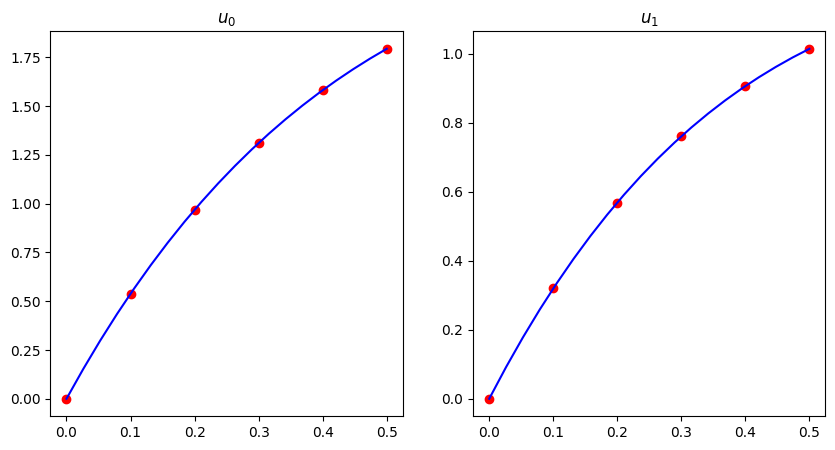

In [6]:
interval = np.linspace(0, 0.5, 6)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].scatter(interval, sol[:, 0], c="red")
axs[0].plot(np.linspace(0, 0.5, 20), [u1(t) for t in np.linspace(0, 0.5, 20)], c="blue")
axs[0].set_title("$u_0$")

axs[1].scatter(interval, sol[:, 1], c="red")
axs[1].plot(np.linspace(0, 0.5, 20), [u2(t) for t in np.linspace(0, 0.5, 20)], c="blue")
axs[1].set_title("$u_1$")

## Método del disparo lineal

In [7]:
def LinearShootingMethod(
    p: Callable[[float], float], 
    q: Callable[[float], float], 
    r: Callable[[float], float], 
    a: float, 
    b: float,
    alpha: float,
    beta: float,
    n: int
    ) -> np.array:
    # Resuelve u'' = p(x)u' + q(x)u + r(x) en [a, b], con condiciones de frontera u(a) = alpha y u(b) = beta
    # n es el número de divisiones del intervalo [a, b]
    
    # funcion que define el primer PVI a resolver
    def F1(t: float, U: np.array) -> np.array:
        return np.array([U[1], p(t)*U[1] + q(t)*U[0] + r(t)])
    
    conditions1 = np.array([alpha, 0])
    system1 = RungeKutta(F1, conditions1, a, b, n)
    u1 = system1[:,0]
    
    # funcion que define el segundo PVI a resolver
    def F2(t: float, U: np.array) -> np.array:
        return np.array([U[1], p(t)*U[1] + q(t)*U[0]])
    
    conditions2 = np.array([0, 1])
    system2 = RungeKutta(F2, conditions2, a, b, n)
    u2 = system2[:,0]
    

    # calculamos la combinación lineal de las soluciones a los PVI anteriores para encontrar el problema con valores en la frontera
    return u1 + ((beta - u1[-1])/u2[-1])*u2

Ejemplo 1:
$$
u'' = -\frac{2}{x}u' + \frac{2}{x^2}u + \frac{\sin(\ln(x))}{x^2}, \quad 1 \leq x\leq 2,
$$
$$
u(1) = 1, \; u(2) = 2.
$$

In [8]:
sol_linear_shooting = LinearShootingMethod(
    p = lambda x: -2/x, 
    q = lambda x: 2/(x**2), 
    r = lambda x: np.sin(np.log(x))/(x**2), 
    a = 1, 
    b = 2, 
    alpha = 1, 
    beta = 2, 
    n = 10
    )
sol_linear_shooting

array([1.        , 1.09262916, 1.18708471, 1.28338227, 1.38144589,
       1.48115939, 1.58239245, 1.68501396, 1.78889854, 1.89392951,
       2.        ])

La solución exacta es:
$$
u(x) = c_1x + \frac{c_2}{x^2} - \frac{3}{10}\sin(\ln(x)) - \frac{1}{10}\cos(\ln(x)), \\
c_2 = \frac{1}{70}[8-12\sin(\ln(2))-4\cos(\ln(2))], \quad c_1 = \frac{11}{10} - c_2
$$

In [9]:
def real_sol(x: float) -> float:
    c2 = (8 - 12*np.sin(np.log(2)) - 4*np.cos(np.log(2)))/70
    c1 = 11/10 - c2
    return c1*x + c2/(x**2) - (3/10)*np.sin(np.log(x)) - (1/10)*np.cos(np.log(x))

Comparación de solución exacta vs aproximación obtenida mediante el método del disparo lineal

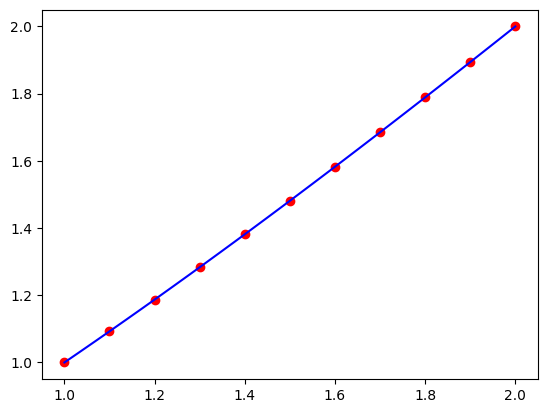

In [10]:
interval = np.linspace(1, 2, 11)
plt.scatter(interval, sol_linear_shooting, c="red")
plt.plot(np.linspace(1, 2, 30), [real_sol(t) for t in np.linspace(1, 2, 30)], c="blue")

## Método del disparo no lineal

In [11]:
def NonLinearShootingMethod(
    f: Callable[[float, float, float], float],
    dfdy: Callable[[float, float, float], float],
    dfdz: Callable[[float, float, float], float],
    a: float, 
    b: float,
    alpha: float,
    beta: float,
    n: int,
    MAX_ITER: int,
    TOL: float = 1e-6,
    ) -> np.array:
    # Resuelve u'' = f(x, u, u') en [a, b], con condiciones de frontera u(a) = alpha y u(b) = beta
    # n es el número de divisiones del intervalo [a, b]
    # Se usa el método del disparo (versión con método de Newton)
    # se ocupa df/dy y df/dz
    
    tk = (beta-alpha)/(b-a) # primer disparo con pendiente de la recta que une (a, alpha) y (b, beta)
    
    for iter in range(MAX_ITER):
        
        # resolvemos u'' = f(x, u, u'), u(a) = alpha, u'(a) = t
        conditions_u = np.array([alpha, tk])
        sol_u = RungeKutta(
            F = lambda x, u: np.array([u[1], f(x, u[0], u[1])]), 
            alpha = conditions_u, 
            a = a, 
            b = b, 
            n = n
            )
        
        if abs(sol_u[-1,0] - beta) <= TOL:
            print(f"Converge en {iter+1} iteraciones")
            print("Valor de t:", tk)
            return sol_u[:, 0]
        
        # resolvemos w''(x,t) = dfdy(x,u,u') w(x,t) + dfdz(x, u, u')w'(x,t)
        conditions_w = np.array([0, 1]) # w(a, t) = 0, w'(a, t) = 1
        u = sol_u[:, 0]
        u_prime = sol_u[:, 1]
        
        # Runge Kutta adaptado para usar las aproximaciones u y u' calculadas anteriormente
        h = (b-a)/n
        xj = a
        W = np.zeros((n+1, 2))
        W[0] = conditions_w
        
        for j in range(1, n+1):
            K1_1 = h*W[j-1, 1]
            K1_2 = h*(
                dfdy(xj, u[j-1], u_prime[j-1])*(W[j-1,0]) 
                + dfdz(xj, u[j-1], u_prime[j-1])*(W[j-1,1])
                )
            K2_1 = h*(W[j-1,1] + K1_2/2)
            
            K2_2 = h*(
                dfdy(xj+h/2, u[j-1], u_prime[j-1])*(W[j-1, 0] + K1_1/2) 
                + dfdz(xj+h/2, u[j-1], u_prime[j-1])*(W[j-1, 1] + K1_2/2)
            )
            K3_1 = h*(W[j-1,1] + K2_2/2)
            K3_2 = h*(
                dfdy(xj+h/2, u[j-1], u_prime[j-1])*(W[j-1, 0] + K2_1/2) 
                + dfdz(xj+h/2, u[j-1], u_prime[j-1])*(W[j-1, 1] + K2_2/2)
            )
            K4_1 = h*(W[j-1,1] + K3_2/2)
            K4_2 = h*(
                dfdy(xj+h, u[j], u_prime[j])*(W[j-1, 0] + K3_1/2)
                + dfdz(xj+h, u[j], u_prime[j])*(W[j-1, 1] + K3_2/2)
            )
            
            W[j,0] = W[j-1,0] + (K1_1 + 2*K2_1 + 2*K3_1 + K4_1)/6
            W[j,1] = W[j-1,1] + (K1_2 + 2*K2_2 + 2*K3_2 + K4_2)/6
            
            xj = a + j*h
        
        tk = tk - (u[-1] - beta)/W[-1,0]
        
    raise Exception("El método no convergió: máximo número de iteraciones alcanzadas")

def NonLinearShootingMethodv2(
    f: Callable[[float, float, float], float],
    a: float, 
    b: float,
    alpha: float,
    beta: float,
    n: int,
    MAX_ITER: int,
    TOL: float = 1e-6,
    ) -> np.array:
    # Resuelve u'' = f(x, u, u') en [a, b], con condiciones de frontera u(a) = alpha y u(b) = beta
    # n es el número de divisiones del intervalo [a, b]
    # Se usa el método del disparo (versión con método de la secante)
    
    tk = (beta-alpha)/(b-a) # t0
    conditions_uk = np.array([alpha, tk])
    sol_uk = RungeKutta(lambda x, u: np.array([u[1], f(x, u[0], u[1])]), conditions_uk, a, b, n)
    
    if abs(sol_uk[-1,0] - beta) <= TOL:
        print(f"Converge en {0} iteraciones")
        print("Valor de t:", tk)
        return sol_uk[:, 0]
    
    
    tk1 = tk + (beta - sol_uk[-1,0])/(b-a)
    conditions_uk1 = np.array([alpha, tk1])
    sol_uk1 = RungeKutta(lambda x, u: np.array([u[1], f(x, u[0], u[1])]), conditions_uk1, a, b, n)
    
    if abs(sol_uk1[-1,0] - beta) <= TOL:
        print(f"Converge en {1} iteraciones")
        print("Valor de t:", tk1)
        return sol_uk1[:, 0]
    
    for iter in range(MAX_ITER):
        tk1_copy = tk1
        tk1 = tk1 - (sol_uk1[-1,0] - beta)*(tk1 - tk)/(sol_uk1[-1,0] - sol_uk[-1, 0])
        tk = tk1_copy
        
        sol_uk = sol_uk1
        conditions_uk1 = np.array([alpha, tk1])
        sol_uk1 = RungeKutta(lambda x, u: np.array([u[1], f(x, u[0], u[1])]), conditions_uk1, a, b, n)
        
        if abs(sol_uk1[-1,0] - beta) <= TOL:
            print(f"Converge en {iter+1} iteraciones")
            print("Valor de t:", tk)
            return sol_uk1[:, 0]
            
        
    raise Exception("El método no convergió: máximo número de iteraciones alcanzadas")
    
    

Ejemplo: 
$$
u'' = \frac{1}{8}(32+2x^3-uu'), \quad 1\leq x \leq 3, \\
u(1) = 17, \; u(3) = \frac{43}{3}.
$$
Solución exacta:
$$
u(x) = x^2 + 16/x
$$

In [12]:
sol_problem = NonLinearShootingMethod(
    f = lambda x, u, du: (1/8)*(32+2*x**3 - u*du), 
    dfdy = lambda x, u, du: -du/8, 
    dfdz = lambda x, u, du: -u/8, 
    a = 1, 
    b = 3, 
    alpha = 17, 
    beta = 43/3, 
    n = 20, 
    MAX_ITER=35
    )
sol_problem

Converge en 6 iteraciones
Valor de t: -14.000191940127298


array([17.        , 15.75549616, 14.77339118, 13.99775431, 13.38863181,
       12.91672273, 12.56005064, 12.3018096 , 12.12892813, 12.03108652,
       12.00002892, 12.02907199, 12.11274752, 12.24653827, 12.42667987,
       12.65001024, 12.91385377, 13.21593123, 13.55428899, 13.92724289,
       14.33333332])

In [13]:
sol_problem2 = NonLinearShootingMethodv2(
    f = lambda x, u, du: (1/8)*(32+2*x**3 - u*du), 
    a = 1, 
    b = 3, 
    alpha = 17, 
    beta = 43/3, 
    n = 20, 
    MAX_ITER= 35
    )
sol_problem2

Converge en 5 iteraciones
Valor de t: -14.000255079260397


array([17.        , 15.75549616, 14.77339118, 13.99775432, 13.38863182,
       12.91672275, 12.56005065, 12.30180962, 12.12892815, 12.03108653,
       12.00002893, 12.029072  , 12.11274753, 12.24653829, 12.42667989,
       12.65001026, 12.91385379, 13.21593125, 13.55428901, 13.92724291,
       14.33333334])

Comparación de solución exacta y aproximación obtenida por el método del disparo

In [14]:
def real_sol_problem(x: float) -> float:
    return x**2 + 16/x

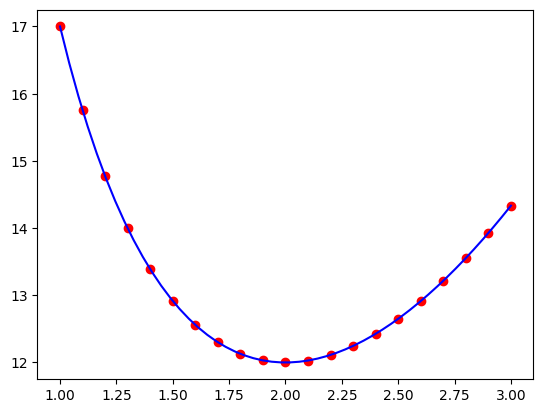

In [15]:
interval = np.linspace(1, 3, 21)
plt.scatter(interval, sol_problem, c="red")
plt.plot(np.linspace(1, 3, 50), [real_sol_problem(x) for x in np.linspace(1, 3, 50)], c="blue")

Iteraciones:

Converge en 5 iteraciones


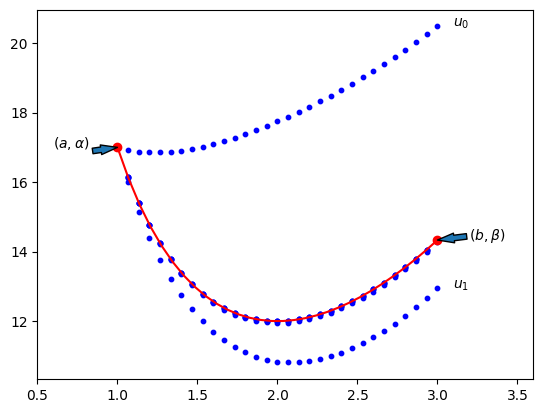

In [16]:
def PlotNonLinearShootingMethod(
    ax: plt.Axes, 
    f: Callable[[float, float, float], float],
    dfdy: Callable[[float, float, float], float],
    dfdz: Callable[[float, float, float], float],
    a: float, 
    b: float,
    alpha: float,
    beta: float,
    n: int,
    MAX_ITER: int,
    TOL: float = 1e-6,
    ) -> np.array:
    
    tk = (beta-alpha)/(b-a) # primer disparo con pendiente de la recta que une (a, alpha) y (b, beta)
    
    interval = np.linspace(a, b, n+1)
    
    epsilon_x = 0.1
    ax.set_xlim(a-5*epsilon_x, b+6*epsilon_x)
    
    
    for iter in range(MAX_ITER):
    
        conditions_y = np.array([alpha, tk])
        sol_u = RungeKutta(lambda x, u: np.array([u[1], f(x, u[0], u[1])]), conditions_y, a, b, n)
        #if iter < draw_first:
        ax.scatter(interval, sol_u[:, 0], c="blue", s=10)
        
        
        if iter < 2:
            ax.annotate(text=f"$u_{iter}$", xy=(b+epsilon_x, sol_u[-1, 0]))

        
        if abs(sol_u[-1,0] - beta) <= TOL:
            print(f"Converge en {iter+1} iteraciones")
            ax.scatter(interval, sol_u[:, 0], c="blue", s=10)
            ax.scatter([a, b], [alpha, beta], c="red")
            ax.annotate(text=f"$(b, \\beta$)", xy=(b, beta), xytext=(b+2*epsilon_x, beta), arrowprops={"headwidth": 7})
            ax.annotate(text=f"$(a, \\alpha)$", xy=(a, alpha), xytext=(a-4*epsilon_x, alpha), arrowprops={"headwidth": 7})
            
            return sol_u[:, 0]
        
        if iter < MAX_ITER - 1: # sólo resolvemos el segundo sistema si habrá una siguiente iteración para la cual se ocuparía tk
            conditions_z = np.array([0, 1])
            u = sol_u[:, 0]
            u_prime = sol_u[:, 1]
            
            # hacemos Runge-Kutta aquí sin mandar a llamar nuestra función porque necesitamos adaptarlo para utilizar las funciones u y u' del primer sistema resuelto
            h = (b-a)/n
            xj = a
            Z = np.zeros((n+1, 2))
            Z[0] = conditions_z
            
            for j in range(1, n+1):
                K1_1 = h*Z[j-1, 1]
                K1_2 = h*(
                    dfdy(xj, u[j-1], u_prime[j-1])*(Z[j-1,0]) 
                    + dfdz(xj, u[j-1], u_prime[j-1])*(Z[j-1,1])
                    )
                K2_1 = h*(Z[j-1,1] + K1_2/2)
                
                # aproximamos u(xj + h/2) con u(xj), lo mismo con u'. Esto pues solo conocemos u y u' en los puntos xj = a + j*h, y no en xj+h/2
                K2_2 = h*(
                    dfdy(xj+h/2, u[j-1], u_prime[j-1])*(Z[j-1, 0] + K1_1/2) 
                    + dfdz(xj+h/2, u[j-1], u_prime[j-1])*(Z[j-1, 1] + K1_2/2)
                )
                K3_1 = h*(Z[j-1,1] + K2_2/2)
                K3_2 = h*(
                    dfdy(xj+h/2, u[j-1], u_prime[j-1])*(Z[j-1, 0] + K2_1/2) 
                    + dfdz(xj+h/2, u[j-1], u_prime[j-1])*(Z[j-1, 1] + K2_2/2)
                )
                K4_1 = h*(Z[j-1,1] + K3_2/2)
                K4_2 = h*(
                    dfdy(xj+h, u[j], u_prime[j])*(Z[j-1, 0] + K3_1/2)
                    + dfdz(xj+h, u[j], u_prime[j])*(Z[j-1, 1] + K3_2/2)
                )
                
                Z[j,0] = Z[j-1,0] + (K1_1 + 2*K2_1 + 2*K3_1 + K4_1)/6
                Z[j,1] = Z[j-1,1] + (K1_2 + 2*K2_2 + 2*K3_2 + K4_2)/6
                
                xj = a + j*h
            
            tk = tk - (u[-1] - beta)/Z[-1,0]
        
    raise Exception("El método no convergió: máximo número de iteraciones alcanzadas")

fig, ax = plt.subplots(1, 1)
PlotNonLinearShootingMethod(ax, lambda x, y, dy: (1/8)*(32+2*x**3 - y*dy), lambda x, y, dy: -dy/8, lambda x, y, dy: -y/8, 1, 3, 17, 43/3, 30, 35, 1e-5)
ax.plot(np.linspace(1, 3, 30), [real_sol_problem(x) for x in np.linspace(1, 3, 30)], c="red")
    

Ejemplo: 
$$
u'' = u^3 - uu', \quad 1\leq x \leq 2, \\
u(1) = 1/2, \; u(2) = \frac{1}{3}.
$$
Solución:
$$
u(x) = \frac{1}{x+1}
$$

In [17]:
sol_problem = NonLinearShootingMethod(
    f = lambda x, u, du: u**3 - u*du, 
    dfdy = lambda x, u, du: 3*u**2 - du, 
    dfdz = lambda x, u, du: -u, 
    a = 1, 
    b = 2, 
    alpha = 1/2, 
    beta = 1/3, 
    n = 20, 
    MAX_ITER=35
    )
sol_problem

Converge en 3 iteraciones
Valor de t: -0.24999960108441727


array([0.5       , 0.4878049 , 0.47619052, 0.46511634, 0.45454554,
       0.44444455, 0.43478273, 0.42553205, 0.41666683, 0.40816344,
       0.4000002 , 0.39215708, 0.38461562, 0.37735874, 0.37037064,
       0.36363665, 0.35714316, 0.35087751, 0.34482793, 0.33898341,
       0.33333371])

In [18]:
NonLinearShootingMethodv2(
    f = lambda x, u, du: u**3 - u*du,
    a = 1, 
    b = 2, 
    alpha = 1/2, 
    beta = 1/3, 
    n = 20, 
    MAX_ITER=35
    )

Converge en 2 iteraciones
Valor de t: -0.2500377103381034


array([0.5       , 0.48780488, 0.47619048, 0.46511628, 0.45454546,
       0.44444445, 0.43478262, 0.42553192, 0.41666668, 0.40816328,
       0.40000001, 0.39215687, 0.3846154 , 0.3773585 , 0.37037038,
       0.36363638, 0.35714287, 0.35087721, 0.3448276 , 0.33898307,
       0.33333335])

Converge en 3 iteraciones


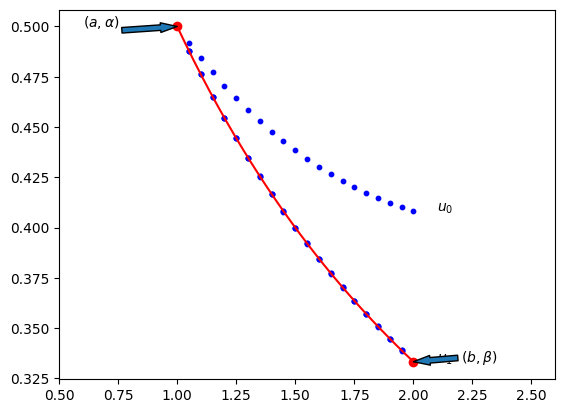

In [19]:
fig, ax = plt.subplots(1, 1)
PlotNonLinearShootingMethod(
    ax, 
    f = lambda x, u, du: u**3 - u*du, 
    dfdy = lambda x, u, du: 3*u**2 - du, 
    dfdz = lambda x, u, du: -u, 
    a = 1, 
    b = 2, 
    alpha = 1/2, 
    beta = 1/3, 
    n = 20, 
    MAX_ITER=35
    )
ax.plot(np.linspace(1, 2, 30), [1/(x+1) for x in np.linspace(1, 2, 30)], c="red")